In [1]:
import os
### QAOA_realestate가 있는 폴더로 지정
dir_path = "/Users/minhyeong-gyu/Documents/GitHub/QAOA_realestate"
os.chdir(dir_path)
import sys
module_path = dir_path + "/Module"
if module_path not in sys.path:
    sys.path.append(module_path)

from optimizer import optimizer as opt
from optimizer import basefunctions as bf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import font_manager, rc
# 윈도우 한글 폰트
# font_path = "C:/Windows/Fonts/NGULIM.TTF"
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)

# Mac 한글 폰트
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

import seaborn as sns
from dwave.system import LeapHybridCQMSampler
%matplotlib inline

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable 
from sklearn.preprocessing import MinMaxScaler

class LSTM1(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM1, self).__init__()
    self.num_classes = num_classes #number of classes
    self.num_layers = num_layers #number of layers
    self.input_size = input_size #input size
    self.hidden_size = hidden_size #hidden state
    self.seq_length = seq_length #sequence length
 
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                      num_layers=num_layers, batch_first=True) #lstm
    self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
    self.fc = nn.Linear(128, num_classes) #fully connected last layer

    self.relu = nn.ReLU() 

  def forward(self,x):
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state   
    # Propagate input through LSTM

    output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
   
    hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
    out = self.relu(hn)
    out = self.fc_1(out) #first Dense
    out = self.relu(out) #relu
    out = self.fc(out) #Final Output
   
    return out 

In [3]:
def transform_window(x,window):
    x = np.asarray(x)
    window_x = []
    for i in range(len(x)-window):
        window_x += [np.exp(sum([np.log(1+x[i+j]) for j in range(window)]))]
    return window_x

def MSE(y_true,y_pred):
    return np.linalg.norm(y_true-y_pred)**2

def MAE(y_true,y_pred):
    return np.linalg.norm(y_true-y_pred,1)

def R_square(y_true,y_pred):
    return 1-np.linalg.norm(y_true-y_pred)**2/np.linalg.norm(y_true-np.mean(y_true))**2

def k_lookback(y, look_back_range=5,look_back_end=0):
    n = len(y)
    y = np.asarray(y)
    y_lb = pd.DataFrame()
    for i in range(look_back_range):
        y_lb[i] = np.asarray(y)[look_back_range-i:n-look_back_end-i]
    return y_lb.values

In [4]:
X1 = pd.read_csv("data/Preprocessed_Data/X1.csv",index_col="Unnamed: 0")
X2 = pd.read_csv("data/Preprocessed_Data/X2.csv",index_col="Unnamed: 0")
X3 = pd.read_csv("data/Preprocessed_Data/X3.csv",index_col="Unnamed: 0")
X4 = pd.read_csv("data/Preprocessed_Data/X4.csv",index_col="Unnamed: 0")
X5 = pd.read_csv("data/Preprocessed_Data/X5.csv",index_col="Unnamed: 0")


y = pd.read_csv("data/Preprocessed_Data/Y.csv")

In [24]:
num_epochs = 3000 #1000 epochs
learning_rate = 0.001 #0.001 lr

look_back_end = 6
look_back = 10
input_size = look_back #number of features
hidden_size = 60 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 
device = torch.device("cpu")

window = 10
ratio = 0.85

In [67]:
y_train_tensors.shape

torch.Size([87, 113])

In [88]:
k=0
MAE_list =[]
test_predict_list = []
test_true_list =[]
y_cumul = pd.DataFrame([[np.exp(sum(np.log(1+y.iloc[:i,dong]))) for dong in range(1,y.shape[1])] for i in range(len(y))])
y_cumul.columns = y.iloc[:,1:].columns
X1_cumulative = [np.exp(sum(np.log(1+X1.iloc[:i,1]))) for i in range(len(X1))]

X1_var = k_lookback(X1_cumulative ,look_back_range= look_back,look_back_end = 0)[look_back_end:]
X2_var = k_lookback(X2.iloc[:,1],look_back_range=look_back,look_back_end = 0)[look_back_end:]
X5_var = k_lookback(X5.iloc[:,1],look_back_range=look_back,look_back_end = 0)[look_back_end:]

for dong in y.columns[1:]:
  y_var = k_lookback(y_cumul.loc[:,dong],look_back_range=look_back,look_back_end = look_back_end)
  X3_var = k_lookback(X3.loc[:,dong],look_back_range=look_back,look_back_end = 0)[look_back_end:]
  X4_var = k_lookback(X4.loc[:,dong],look_back_range=look_back,look_back_end = 0)[look_back_end:]

  X_df = np.array([[i1,i2,i3,i4,i5,i6] for i1,i2,i3,i4,i5,i6 in zip(y_var,X1_var,X2_var,X3_var,X4_var,X5_var)])
  train_split = int(ratio*len(X_df))

  X_train = X_df[:train_split,:]
  X_test = X_df[train_split:,:]
  y_df = np.array(y_cumul.loc[:,dong])[look_back+look_back_end:]
  y_train = y_df[:train_split]
  y_test = y_df[train_split:]

  X_train_tensors_final = Variable(torch.Tensor(X_train))
  X_test_tensors_final = Variable(torch.Tensor(X_test))

  y_train_tensors = Variable(torch.Tensor(y_train))
  y_test_tensors = Variable(torch.Tensor(y_test))

  lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)
  loss_function = torch.nn.L1Loss()    # mean-squared error for regression
  optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)  # adam optimizer

  for epoch in range(num_epochs):
    outputs = lstm1.forward(X_train_tensors_final.to(device)) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0
    # obtain the loss function
    loss = loss_function(outputs.squeeze(), y_train_tensors.to(device))
    loss.backward() #calculates the loss of the loss function
    optimizer.step() #improve from loss, i.e backprop
  torch.save(lstm1.state_dict(),"./data/model_parameters/lstm_parameters_"+dong)
  train_predict = lstm1(X_train_tensors_final.to(device)).detach().numpy()#forward pass
  test_predict = lstm1(X_test_tensors_final.to(device)).detach().numpy()#forward pass
  test_predict_list += [test_predict.reshape(-1).tolist()]
  test_true_list += [y_test_tensors.numpy().tolist()]
  MAE_list += [MAE(test_predict.reshape(-1),y_test_tensors.numpy())]
  k = k+1
  if k%5 == 0 : print("Succeed train"+ str(k) + "numbers of region")

Succeed train5numbers of region
Succeed train10numbers of region
Succeed train15numbers of region
Succeed train20numbers of region
Succeed train25numbers of region
Succeed train30numbers of region
Succeed train35numbers of region
Succeed train40numbers of region
Succeed train45numbers of region
Succeed train50numbers of region
Succeed train55numbers of region
Succeed train60numbers of region
Succeed train65numbers of region
Succeed train70numbers of region
Succeed train75numbers of region
Succeed train80numbers of region
Succeed train85numbers of region
Succeed train90numbers of region
Succeed train95numbers of region
Succeed train100numbers of region
Succeed train105numbers of region
Succeed train110numbers of region


In [94]:
test_length = len(y_test)

In [95]:
ratio_list = [np.mean(1+y.iloc[:train_split,dong])for dong in range(1,y.shape[1])]
y_criterion = [np.exp(sum(np.log(1+y.iloc[:train_split,dong]))) for dong in range(1,y.shape[1])]
test_mean_list = [[y_criterion[j]*ratio_list[j]**i for i in range(test_length)] for j in range(y.shape[1]-1)]

In [108]:
MAE_mean = np.apply_along_axis(sum,0,np.abs(y_cumul.iloc[103:].values-pd.DataFrame(test_mean_list ).T.values))

In [212]:
pd.DataFrame(test_predict_list).T.to_csv("./Experiment/MHG/full_predict_result.csv")

In [123]:
X1_criterion = X1_cumulative[-test_length]

In [145]:
test_length

16

In [179]:
lower_case = 0.005
mean_case = 0.01
upper_case = 0.02
n = len(X1_cumulative)
X1_criterion = X1_cumulative[train_split-1]
X1_test_lower = [X1_criterion*(1+lower_case)**i for i in range(n-train_split)]
X1_test_mean = [X1_criterion*(1+mean_case)**i for i in range(n-train_split)]
X1_test_real = X1_cumulative[train_split:]
X1_test_upper = [X1_criterion*(1+upper_case)**i for i in range(n-train_split)]


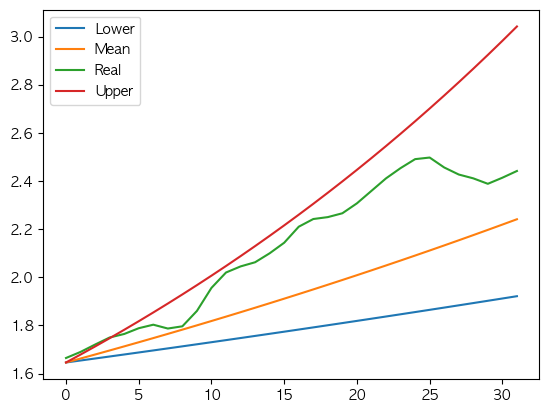

In [180]:
plt.plot(X1_test_lower,label="Lower")
plt.plot(X1_test_mean,label="Mean")
plt.plot(X1_test_real,label="Real")
plt.plot(X1_test_upper,label="Upper")
plt.legend()
plt.show()

In [182]:
X1_lower = X1_cumulative[:train_split]+X1_test_lower
X1_mean = X1_cumulative[:train_split]+X1_test_mean
X1_upper = X1_cumulative[:train_split]+X1_test_upper

In [214]:
X1_target = X1_cumulative

test_predict_list = []
X1_var = k_lookback(X1_target,look_back_range= look_back,look_back_end = 0)[look_back_end:]
X2_var = k_lookback(X2.iloc[:,1],look_back_range=look_back,look_back_end = 0)[look_back_end:]
X5_var = k_lookback(X5.iloc[:,1],look_back_range=look_back,look_back_end = 0)[look_back_end:]

for dong in y.columns[1:]:
  y_var = k_lookback(y_cumul.loc[:,dong],look_back_range=look_back,look_back_end = look_back_end)
  X3_var = k_lookback(X3.loc[:,dong],look_back_range=look_back,look_back_end = 0)[look_back_end:]
  X4_var = k_lookback(X4.loc[:,dong],look_back_range=look_back,look_back_end = 0)[look_back_end:]

  X_df = np.array([[i1,i2,i3,i4,i5,i6] for i1,i2,i3,i4,i5,i6 in zip(y_var,X1_var,X2_var,X3_var,X4_var,X5_var)])
  train_split = int(ratio*len(X_df))

  X_train = X_df[:train_split,:]
  X_test = X_df[train_split:,:]
  y_df = np.array(y_cumul.loc[:,dong])[look_back+look_back_end:]
  y_train = y_df[:train_split]
  y_test = y_df[train_split:]

  X_train_tensors_final = Variable(torch.Tensor(X_train))
  X_test_tensors_final = Variable(torch.Tensor(X_test))

  y_train_tensors = Variable(torch.Tensor(y_train))
  y_test_tensors = Variable(torch.Tensor(y_test))

  lstm1.load_state_dict(torch.load("./data/model_parameters/lstm_parameters_"+dong))
  test_predict = lstm1(X_test_tensors_final.to(device)).detach().numpy().reshape(-1)#forward pass
  test_predict_list += [test_predict.tolist()]
pd.DataFrame(test_predict_list).T.to_csv("./Experiment/MHG/full_predict_result.csv")

In [215]:
X1_target = X1_lower

test_predict_list = []
X1_var = k_lookback(X1_target,look_back_range= look_back,look_back_end = 0)[look_back_end:]
X2_var = k_lookback(X2.iloc[:,1],look_back_range=look_back,look_back_end = 0)[look_back_end:]
X5_var = k_lookback(X5.iloc[:,1],look_back_range=look_back,look_back_end = 0)[look_back_end:]

for dong in y.columns[1:]:
  y_var = k_lookback(y_cumul.loc[:,dong],look_back_range=look_back,look_back_end = look_back_end)
  X3_var = k_lookback(X3.loc[:,dong],look_back_range=look_back,look_back_end = 0)[look_back_end:]
  X4_var = k_lookback(X4.loc[:,dong],look_back_range=look_back,look_back_end = 0)[look_back_end:]

  X_df = np.array([[i1,i2,i3,i4,i5,i6] for i1,i2,i3,i4,i5,i6 in zip(y_var,X1_var,X2_var,X3_var,X4_var,X5_var)])
  train_split = int(ratio*len(X_df))

  X_train = X_df[:train_split,:]
  X_test = X_df[train_split:,:]
  y_df = np.array(y_cumul.loc[:,dong])[look_back+look_back_end:]
  y_train = y_df[:train_split]
  y_test = y_df[train_split:]

  X_train_tensors_final = Variable(torch.Tensor(X_train))
  X_test_tensors_final = Variable(torch.Tensor(X_test))

  y_train_tensors = Variable(torch.Tensor(y_train))
  y_test_tensors = Variable(torch.Tensor(y_test))

  lstm1.load_state_dict(torch.load("./data/model_parameters/lstm_parameters_"+dong))
  test_predict = lstm1(X_test_tensors_final.to(device)).detach().numpy().reshape(-1)#forward pass
  test_predict_list += [test_predict.tolist()]
pd.DataFrame(test_predict_list).T.to_csv("./Experiment/MHG/lower_predict_result.csv")

In [ ]:
X1_target = X1_lower

test_predict_list = []
X1_var = k_lookback(X1_target,look_back_range= look_back,look_back_end = 0)[look_back_end:]
X2_var = k_lookback(X2.iloc[:,1],look_back_range=look_back,look_back_end = 0)[look_back_end:]
X5_var = k_lookback(X5.iloc[:,1],look_back_range=look_back,look_back_end = 0)[look_back_end:]

for dong in y.columns[1:]:
  y_var = k_lookback(y_cumul.loc[:,dong],look_back_range=look_back,look_back_end = look_back_end)
  X3_var = k_lookback(X3.loc[:,dong],look_back_range=look_back,look_back_end = 0)[look_back_end:]
  X4_var = k_lookback(X4.loc[:,dong],look_back_range=look_back,look_back_end = 0)[look_back_end:]

  X_df = np.array([[i1,i2,i3,i4,i5,i6] for i1,i2,i3,i4,i5,i6 in zip(y_var,X1_var,X2_var,X3_var,X4_var,X5_var)])
  train_split = int(ratio*len(X_df))

  X_train = X_df[:train_split,:]
  X_test = X_df[train_split:,:]
  y_df = np.array(y_cumul.loc[:,dong])[look_back+look_back_end:]
  y_train = y_df[:train_split]
  y_test = y_df[train_split:]

  X_train_tensors_final = Variable(torch.Tensor(X_train))
  X_test_tensors_final = Variable(torch.Tensor(X_test))

  y_train_tensors = Variable(torch.Tensor(y_train))
  y_test_tensors = Variable(torch.Tensor(y_test))

  lstm1.load_state_dict(torch.load("./data/model_parameters/lstm_parameters_"+dong))
  test_predict = lstm1(X_test_tensors_final.to(device)).detach().numpy().reshape(-1)#forward pass
  test_predict_list += [test_predict.tolist()]
pd.DataFrame(test_predict_list).T.to_csv("./Experiment/MHG/lower_predict_result.csv")

In [216]:
X1_target = X1_mean

test_predict_list = []
X1_var = k_lookback(X1_target,look_back_range= look_back,look_back_end = 0)[look_back_end:]
X2_var = k_lookback(X2.iloc[:,1],look_back_range=look_back,look_back_end = 0)[look_back_end:]
X5_var = k_lookback(X5.iloc[:,1],look_back_range=look_back,look_back_end = 0)[look_back_end:]

for dong in y.columns[1:]:
  y_var = k_lookback(y_cumul.loc[:,dong],look_back_range=look_back,look_back_end = look_back_end)
  X3_var = k_lookback(X3.loc[:,dong],look_back_range=look_back,look_back_end = 0)[look_back_end:]
  X4_var = k_lookback(X4.loc[:,dong],look_back_range=look_back,look_back_end = 0)[look_back_end:]

  X_df = np.array([[i1,i2,i3,i4,i5,i6] for i1,i2,i3,i4,i5,i6 in zip(y_var,X1_var,X2_var,X3_var,X4_var,X5_var)])
  train_split = int(ratio*len(X_df))

  X_train = X_df[:train_split,:]
  X_test = X_df[train_split:,:]
  y_df = np.array(y_cumul.loc[:,dong])[look_back+look_back_end:]
  y_train = y_df[:train_split]
  y_test = y_df[train_split:]

  X_train_tensors_final = Variable(torch.Tensor(X_train))
  X_test_tensors_final = Variable(torch.Tensor(X_test))

  y_train_tensors = Variable(torch.Tensor(y_train))
  y_test_tensors = Variable(torch.Tensor(y_test))

  lstm1.load_state_dict(torch.load("./data/model_parameters/lstm_parameters_"+dong))
  test_predict = lstm1(X_test_tensors_final.to(device)).detach().numpy().reshape(-1)#forward pass
  test_predict_list += [test_predict.tolist()]
pd.DataFrame(test_predict_list).T.to_csv("./Experiment/MHG/mean_predict_result.csv")

In [217]:
X1_target = X1_upper

test_predict_list = []
X1_var = k_lookback(X1_target,look_back_range= look_back,look_back_end = 0)[look_back_end:]
X2_var = k_lookback(X2.iloc[:,1],look_back_range=look_back,look_back_end = 0)[look_back_end:]
X5_var = k_lookback(X5.iloc[:,1],look_back_range=look_back,look_back_end = 0)[look_back_end:]

for dong in y.columns[1:]:
  y_var = k_lookback(y_cumul.loc[:,dong],look_back_range=look_back,look_back_end = look_back_end)
  X3_var = k_lookback(X3.loc[:,dong],look_back_range=look_back,look_back_end = 0)[look_back_end:]
  X4_var = k_lookback(X4.loc[:,dong],look_back_range=look_back,look_back_end = 0)[look_back_end:]

  X_df = np.array([[i1,i2,i3,i4,i5,i6] for i1,i2,i3,i4,i5,i6 in zip(y_var,X1_var,X2_var,X3_var,X4_var,X5_var)])
  train_split = int(ratio*len(X_df))

  X_train = X_df[:train_split,:]
  X_test = X_df[train_split:,:]
  y_df = np.array(y_cumul.loc[:,dong])[look_back+look_back_end:]
  y_train = y_df[:train_split]
  y_test = y_df[train_split:]

  X_train_tensors_final = Variable(torch.Tensor(X_train))
  X_test_tensors_final = Variable(torch.Tensor(X_test))

  y_train_tensors = Variable(torch.Tensor(y_train))
  y_test_tensors = Variable(torch.Tensor(y_test))

  lstm1.load_state_dict(torch.load("./data/model_parameters/lstm_parameters_"+dong))
  test_predict = lstm1(X_test_tensors_final.to(device)).detach().numpy().reshape(-1)#forward pass
  test_predict_list += [test_predict.tolist()]
pd.DataFrame(test_predict_list).T.to_csv("./Experiment/MHG/upper_predict_result.csv")